## **データ読み込み軍団**

In [64]:
#GPU処理になっているかの確認
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

In [0]:
#googledriveAPIとpythonを連携する PyDriveをcolab上にインストール
# ! をつかうとコマンドが使える

!pip install -U -q PyDrive

In [0]:
#ログインしているアカウントとgoogleドライブを連携する

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [0]:
#ローカルからアップロードするとき用いる
# from google.colab import files
# uploaded = files.upload()

In [0]:
#犬猫写真データをドライブからもってくる

id = '1YacZJ9yYDmwew_FivQIrHBNowC9nSfDR'  # 共有リンクで取得した id= より後の部分
downloaded = drive.CreateFile({'id': id})
downloaded.GetContentFile('dogs-vs-cats-redux-kernels-edition.zip')

In [0]:
#学習済み重みをドライブからもってくる

id = '1O05JOK_gxOu2iipU8S4RQv0oeINrnn4B'  # 共有リンクで取得した id= より後の部分
downloaded = drive.CreateFile({'id': id})
downloaded.GetContentFile('weights.zip')

In [0]:
!unzip dogs-vs-cats-redux-kernels-edition.zip

In [0]:
!unzip test.zip
!unzip train.zip

In [0]:
!unzip weights.zip

In [0]:
#全ての犬猫写真データから1000枚と400枚抜き出す
#この1000枚を訓練データとする
#400枚を検証データとする

import os
source_dir = "./train"
train_dir = "./data/train"
valid_dir = "./data/validation"
result_dir = "./results"

if not os.path.exists("%s/dogs" % train_dir):
  os.makedirs("%s/dogs" % train_dir)
  
if not os.path.exists("%s/cats" % train_dir):
  os.makedirs("%s/cats" % train_dir)
  
if not os.path.exists("%s/dogs" % valid_dir):
  os.makedirs("%s/dogs" % valid_dir)
  
if not os.path.exists("%s/cats" % valid_dir):
  os.makedirs("%s/cats" % valid_dir)
  
if not os.path.exists(result_dir):
  os.makedirs("./results")


# 最初の1000枚の画像をtrain_dirに移動，移動なので元あった場所のファイルはなくなる
for i in range(1000):
    os.rename("%s/dog.%d.jpg" % (source_dir, i + 1), "%s/dogs/dog%04d.jpg" % (train_dir, i + 1))
    os.rename("%s/cat.%d.jpg" % (source_dir, i + 1), "%s/cats/cat%04d.jpg" % (train_dir, i + 1))

# 次の400枚の画像をvalid_dirに移動
for i in range(400):
    os.rename("%s/dog.%d.jpg" % (source_dir, 1000 + i + 1), "%s/dogs/dog%04d.jpg" % (valid_dir, i + 1))
    os.rename("%s/cat.%d.jpg" % (source_dir, 1000 + i + 1), "%s/cats/cat%04d.jpg" % (valid_dir, i + 1))
    
print("end cell")

In [0]:
#データ入ってるか確認用
!ls data/train/dogs

# Mnist 分類器の作成

In [0]:
#必要なライブラリのインポート

from keras import backend as K
from keras.models import Sequential, Model
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers.core import Activation
from keras.layers.core import Flatten
from keras.layers.core import Dense
from keras.layers import Input, Dropout
from keras.datasets import mnist
from keras.utils import np_utils
from keras import optimizers
import numpy as np
import os
print("end cell")

In [0]:
#ハイパパラメータたち
INPUT_SHAPE = (1, 28, 28)
CLASSES_NUM = 10
EPOCH_NUM = 10
BATCH_SIZE = 128
K.set_image_dim_ordering('th')

In [0]:
#モデル
model = Sequential()

model.add(Conv2D(filters=20, kernel_size=5, padding='same',input_shape=INPUT_SHAPE))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

model.add( Conv2D(filters=50, kernel_size=5, padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

model.add(Flatten())
model.add(Dense(500))
model.add(Activation('relu'))

model.add(Dense(units=CLASSES_NUM))
model.add(Activation('softmax'))

In [52]:
#mnistのロードと画素の正規化

(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

11493376/11490434 [==============================] - 1s 0us/step


In [0]:
#cnnに入れられるよう軸を増やす

x_train = x_train[:, np.newaxis, :, :]
x_test = x_test[:, np.newaxis, :, :]

#ラベルをone-hot vector化
y_train = np_utils.to_categorical(
    y=y_train, num_classes=CLASSES_NUM)
y_test = np_utils.to_categorical(
    y=y_test, num_classes=CLASSES_NUM)

In [60]:
#モデルのコンパイルと学習
model.compile(
    loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

#verbose...データをどこまでログに出すか
#validation_split 検証データの割合
history = model.fit(
    x=x_train, y=y_train, batch_size=BATCH_SIZE,
    epochs=EPOCH_NUM, verbose=2, validation_split=0.2)

Test = x_train[0]
Test = Test[:, np.newaxis, :, :]

test = model.predict(Test)

print("Input: {}".format(np.argmax(y_train[0])))
print("Predict: {}".format(np.argmax(test)))

Train on 48000 samples, validate on 12000 samples
Epoch 1/10
 - 4s - loss: 0.0026 - acc: 0.9994 - val_loss: 0.0873 - val_acc: 0.9883
Epoch 2/10
 - 3s - loss: 0.0031 - acc: 0.9991 - val_loss: 0.0689 - val_acc: 0.9900
Epoch 3/10
 - 3s - loss: 2.8535e-04 - acc: 0.9999 - val_loss: 0.0666 - val_acc: 0.9915
Epoch 4/10
 - 2s - loss: 3.7854e-04 - acc: 0.9999 - val_loss: 0.0697 - val_acc: 0.9913
Epoch 5/10
 - 2s - loss: 0.0024 - acc: 0.9994 - val_loss: 0.0732 - val_acc: 0.9893
Epoch 6/10
 - 3s - loss: 0.0025 - acc: 0.9994 - val_loss: 0.0760 - val_acc: 0.9897
Epoch 7/10
 - 3s - loss: 0.0030 - acc: 0.9994 - val_loss: 0.0655 - val_acc: 0.9906
Epoch 8/10
 - 3s - loss: 0.0016 - acc: 0.9995 - val_loss: 0.0642 - val_acc: 0.9917
Epoch 9/10
 - 3s - loss: 5.1657e-04 - acc: 0.9999 - val_loss: 0.0554 - val_acc: 0.9929
Epoch 10/10
 - 3s - loss: 2.0301e-05 - acc: 1.0000 - val_loss: 0.0578 - val_acc: 0.9932
Input: 5
Predict: 5


#犬猫分類器の作成



## **前置き**

In [23]:
#必要なライブラリのインポート

from keras import backend as K
from keras.applications.vgg16 import VGG16
from keras.models import Sequential, Model
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers.core import Activation
from keras.layers.core import Flatten
from keras.layers.core import Dense
from keras.layers import Input, Dropout
from keras.datasets import mnist
from keras.utils import np_utils
from keras import optimizers
from keras.preprocessing.image import ImageDataGenerator
import numpy as np
import os
print("end cell")

end cell


In [24]:
#学習時のlossや検証データでの正答率を記録する関数

def save_history(history, result_file):
    print(history.history.keys())
    loss = history.history['loss']
    acc = history.history['acc']
    val_loss = history.history['val_loss']
    val_acc = history.history['val_acc']
    nb_epoch = len(acc)

    with open(result_file, "w") as fp:
        fp.write("epoch\tloss\tacc\tval_loss\tval_acc\n")
        for i in range(nb_epoch):
            fp.write("%d\t%f\t%f\t%f\t%f\n" % (i, loss[i], acc[i], val_loss[i], val_acc[i]))
print("end cell")
          

end cell


In [30]:
#画像の大きさ，訓練データのパス，epoch数などを設定

img_width, img_height = 150, 150
train_data_dir = './data/train'
validtion_data_dir = './data/validation'
nb_train_samples = 2000
nb_validation_samples = 800
nb_epochs = 20
result_dir = './results'

print("end cell")

end cell


## 自作モデル

畳み込み2層

In [0]:
#モデルの作成
model = Sequential()
model.add(Conv2D(32, 3, 3, input_shape=(150, 150, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, 3, 3))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))


model.add(Flatten())
model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(1))
model.add(Activation('sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

# 訓練データとバリデーションデータを生成するジェネレータを作成
train_datagen = ImageDataGenerator(
    rescale=1.0 / 255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale=1.0 / 255)

train_generator = train_datagen.flow_from_directory(
    'data/train',
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
    'data/validation',
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary')

# 訓練
history = model.fit_generator(
    train_generator,
    samples_per_epoch=2000,
    nb_epoch=nb_epochs,
    validation_data=validation_generator,
    nb_val_samples=800)

# 結果を保存
model.save_weights(os.path.join(result_dir, 'smallcnn.h5'))
save_history(history, os.path.join(result_dir, 'history_smallcnn.txt'))

**predict**

input: sample_cat2.jpg


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:25: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (3, 3), input_shape=(150, 150,...)`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:29: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (3, 3))`


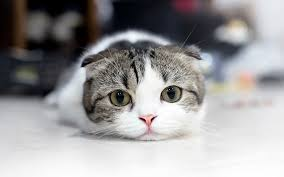

dog


In [38]:
import os
import sys
from keras.applications.vgg16 import VGG16
from keras.models import Sequential, Model
from keras.layers import Input, Activation, Dropout, Flatten, Dense
from keras.preprocessing import image
from IPython.display import Image, display_jpeg
import numpy as np

#ローカル用
# if len(sys.argv) != 2:
#   print("usage: python predict.py [filename]")
#   sys.exit(1)
  
# filename = sys.argv[1]
filename = "sample_cat2.jpg"
print("input:",filename)

result_dir = "./results"
img_height, img_width = 150, 150
channels = 3

#モデルの作成
model = Sequential()
model.add(Conv2D(32, 3, 3, input_shape=(150, 150, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, 3, 3))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))


model.add(Flatten())
model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(1))
model.add(Activation('sigmoid'))


#学習済みモデルをロード，コンパイル
model.load_weights(os.path.join(result_dir, 'smallcnn.h5'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# 画像をパスを参照して読み込み，ついでにサイズを調整する
# cnnに入れるため，軸を一つ増やし，4次元テンソルへ変換 (h,w,rgb) -> (batchsize, h, w, rgb) 今回は軸増やすだけなのでbatchsize = 1となる
img = image.load_img(filename, target_size = (img_height, img_width))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)

#今回のモデルではcnnに入れる際，rgbを正規化する必要がある
x = x/255.0


#画像表示
display_jpeg(Image(filename))

#推測，2値分類なので，0.5をボーダーとし，高いか低いかで判定
pred = model.predict(x)[0]

if pred < 0.5:
  print("cat")
else:
  print("dog")


## VGG16のfinetuning
1epoch 132秒 2分12秒

50epoch 1時間40分？？

やってられないので20epoch 40分ちょい にした

validationがめっちゃ時間かかる


In [0]:


#VGG16モデルをロード，ここは学習せず特徴抽出器として使う
#学習を凍結させる処理は後ろで
input_tensor = Input(shape=(img_height, img_width, 3))
vgg16_model = VGG16(include_top = False, weights='imagenet', input_tensor = input_tensor)

#全結合層構築
top_model = Sequential()
top_model.add(Flatten(input_shape = vgg16_model.output_shape[1:]))
top_model.add(Dense(256, activation='relu'))
top_model.add(Dropout(0.5))
top_model.add(Dense(1, activation='sigmoid'))

#下のようにすれば多クラス分類にも対応できる
# top_model.add(Dense(units=クラス数))
# top_model.add(Activation('softmax'))



#Funcrional APIを使って vggと全結合層をつなげる
model = Model(input = vgg16_model.input, output=top_model(vgg16_model.output))
print('vgg16_model:', vgg16_model)
print('top_model:', top_model)
print('model:', model)
model.summary()

for i in range(len(model.layers)):
  print(i, model.layers[i])
  
for layer in model.layers[:15]:
  layer.trainable = False

model.summary()

model.compile(loss='binary_crossentropy', optimizer = optimizers.SGD(lr=1e-4, momentum = 0.9), metrics=['accuracy'])

#rescale...各画素の情報を0-255から0-1に変換
train_datagen = ImageDataGenerator(rescale=1.0/255, shear_range = 0.2, zoom_range =0.2, horizontal_flip = True)
test_datagen = ImageDataGenerator(rescale =1.0 / 255)

#訓練データにaugmentationをかけたデータを出力する生成器
#ImageDataGenerator.flow_directoryが勝手に指定したディレクトリ下のディレクトリを探査，発見したディレクトリ下のファイルに自動でラベルつける
train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size = (img_height, img_width),
    batch_size = 32,
    class_mode='binary'
)


validation_generator = test_datagen.flow_from_directory(
    validtion_data_dir,
    target_size = (img_height, img_width),
    batch_size = 32,
    class_mode='binary'
)

#ファインチューニング
history = model.fit_generator(
    train_generator,
    samples_per_epoch=nb_train_samples,
    nb_epoch = nb_epochs,
    validation_data = validation_generator,
    nb_val_samples=nb_validation_samples

)

model.save_weights(os.path.join(result_dir, 'finetuning.h5'))
save_history(history, os.path.join(result_dir, 'history_finetuning.txt'))



### predict

In [0]:
import os
import sys
from keras.applications.vgg16 import VGG16
from keras.models import Sequential, Model
from keras.layers import Input, Activation, Dropout, Flatten, Dense
from keras.preprocessing import image
from IPython.display import Image, display_jpeg
import numpy as np

#ローカル用
# if len(sys.argv) != 2:
#   print("usage: python predict.py [filename]")
#   sys.exit(1)
  
# filename = sys.argv[1]
filename = "BUN.jpg"
print("input:",filename)

result_dir = "./results"
img_height, img_width = 150, 150
channels = 3

#vgg16のロード
input_tensor = Input(shape=(img_height, img_width, channels))
vgg16_model = VGG16(include_top = False, weights = 'imagenet', input_tensor=input_tensor)

#全結合層作成
top_model = Sequential()
top_model.add(Flatten(input_shape=vgg16_model.output_shape[1:]))
top_model.add(Dense(256, activation='relu'))
top_model.add(Dropout(0.5))
top_model.add(Dense(1, activation='sigmoid'))

#vgg16と全結合層を結合
model = Model(input=vgg16_model.input, output=top_model(vgg16_model.output))

#学習済みモデルをロード，コンパイル，学習しないのでoptimizerは適当でも大丈夫
model.load_weights(os.path.join(result_dir, 'finetuning_catdogs.h5'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# 画像をコマンドライン引数でとったパスを参照して読み込み，ついでにサイズを調整する
# cnnに入れるため，軸を一つ増やし，4次元テンソルへ変換 (h,w,rgb) -> (batchsize, h, w, rgb) 今回は軸増やすだけなのでbatchsize = 1となる
img = image.load_img(filename, target_size = (img_height, img_width))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)

#今回のモデルではcnnに入れる際，正規化する必要がある
x = x/255.0


#画像表示
display_jpeg(Image(filename))

#推測
pred = model.predict(x)[0]
print(pred)

if pred < 0.5:
  print("cat")
else:
  print("dog")


